<font face = "Computer Modern", size = 3>
<ul> To Do List
    <li> Check how noise scales with mean </li>
    <li> Look at a histogram of pixel values of the natural images... maybe subtract the mean, and scale by STD? </li>
    <li> Add history filter to the design matrix </li>
    <li> Be really sure about what you're doing in terms of selecting cells. Want about 5 cells with good orientation selectivity, good receptive field, and strong responses to natural scenes. </li>
    <li> Use fast oopsi to deconvolve to spikes (for poisson) </li>
    <li> Try deconvolving to 'rate' </li>
    <li> Hyper-parameter search over learning rate, regularization, and initialization of scale and offset parameters for *each* GLM (poisson, gamma, and  </li>
    <li> TRY initialization small random weights </li>
    <li> Beg Jonathan Pillow for help. </li>
    

In [159]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glm_model as gm
import pprint

%load_ext autoreload
%autoreload 2
%matplotlib inline
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
import pandas as pd

# Download experiment containers for VISp experiments
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'])
print("all VISp experiment containers: %d" % len(visp_ecs))

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))
# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("VISp cells: %d" % len(visp_cells))

# significant response to drifting gratings stimulus
sig_cells = visp_cells[visp_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['dsi_dg'] > 0.5) & (sig_cells['dsi_dg'] < 1.5)]
print("direction-selective cells: %d" % len(dsi_cells))

all VISp experiment containers: 25
total cells: 18260
VISp cells: 7167
cells with sig. response to drifting gratings: 4179
direction-selective cells: 2257


In [161]:
import allensdk.brain_observatory.stimulus_info as stim_info

# find experiment containers for those cells
dsi_ec_ids = dsi_cells['experiment_container_id'].unique()
print("total dsi experiment containers: %d" % len(dsi_ec_ids))

# Download the ophys experiments containing the natural scenes stimulus for VISp experiment containers
dsi_exps = boc.get_ophys_experiments(experiment_container_ids=dsi_ec_ids, stimuli=[stim_info.NATURAL_SCENES])
print("VISp drifting gratings ophys experiments: %d" % len(dsi_exps))

print("Example ophys experiment:")
pprint.pprint(dsi_exps[1])

total dsi experiment containers: 25
VISp drifting gratings ophys experiments: 25
Example ophys experiment:
{'age_days': 132.0,
 'cre_line': u'Cux2-CreERT2',
 'experiment_container_id': 511510779,
 'id': 503019786,
 'imaging_depth': 275,
 'session_type': u'three_session_B',
 'targeted_structure': u'VISp'}


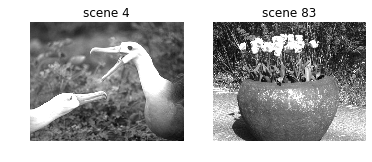

In [212]:
csid = 503019786

data_set = boc.get_ophys_experiment_data(csid)

scene_nums = [4, 83]

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# display a couple of the scenes

fig, axes = plt.subplots(1,len(scene_nums))
for ax,scene in zip(axes, scene_nums):
    ax.imshow(scenes[scene,:,:], cmap='gray')
    ax.set_axis_off()
    ax.set_title('scene %d' % scene)
    

In [214]:
data_set.get_cell_specimen_ids()

array([517519164, 517518210, 517517236, 517517437, 517517943, 517517877,
       517517532, 517519352, 517517874, 517519310, 517519315, 517517920,
       517519006, 517517454, 517519526, 517517464, 517519109, 517519204,
       517519327, 517519658, 517519492, 517519502, 517519487, 517519472,
       517519467, 517519719, 517519477, 517517769, 517518790, 517517749,
       517517685, 517519582, 517519244, 517518487, 517517318, 517517323,
       517519439, 517517353, 517517827, 517519219, 517519572, 517518524,
       517518539, 517518463, 517519397, 517517821, 517517427, 517519443,
       517519856, 517518128, 517517547, 517518744, 517517953, 517517958,
       517518521, 517517981, 517517513, 517517948, 517518194, 517517968,
       517517973, 517517226, 517517522, 517517231, 517517444, 517517925,
       517518045, 517518335, 517519497, 517519094, 517519249, 517518544,
       517517622, 517517494, 517519457, 517519641, 517517963, 517517986,
       517517285, 517519645, 517518534, 517518549, 

In [215]:
#lets find the receptive field of this cell
#ONLY HAVE TO EXECUTE THIS CELL ONCE per dataset, I think, it computes it for the whole experiment. 

#data_set = dsi_exps[1]
csid = 517519808

from allensdk.brain_observatory.locally_sparse_noise import LocallySparseNoise
import allensdk.brain_observatory.stimulus_info as stim_info

cell = boc.get_cell_specimens(ids=[csid])[0]

exp = boc.get_ophys_experiments(experiment_container_ids=[cell['experiment_container_id']],
                                stimuli=[stim_info.LOCALLY_SPARSE_NOISE])[0]
                                         
data_set = boc.get_ophys_experiment_data(exp['id'])
lsn = LocallySparseNoise(data_set)
print("done analyzing locally sparse noise")


Calculating mean responses
done analyzing locally sparse noise


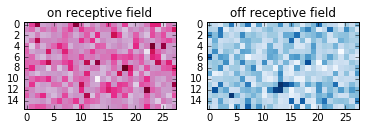

In [216]:
#csid = data_set.get_cell_specimen_ids()[21]

specimen_ids = data_set.get_cell_specimen_ids()
cell_loc = np.argwhere(specimen_ids==csid)[0][0]

plt.subplot(221)
plt.imshow(lsn.receptive_field[:,:,cell_loc,0], interpolation='nearest', cmap='PuRd')
plt.title("on receptive field")
plt.subplot(222)
plt.imshow(lsn.receptive_field[:,:,cell_loc,1], interpolation='nearest', cmap='Blues')
plt.title("off receptive field")



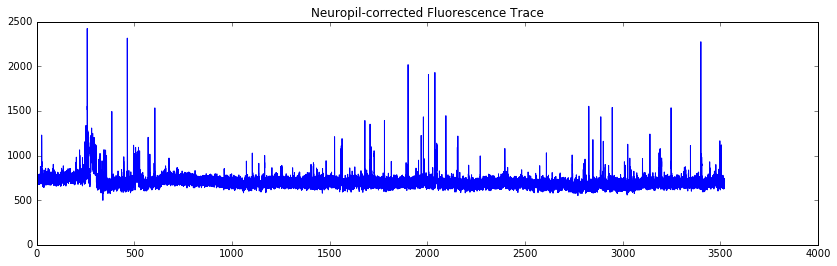

In [222]:
time, corrected_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[csid])

plt.figure(figsize=(14,4))
plt.title("Neuropil-corrected Fluorescence Trace")
plt.plot(time, corrected_traces[0])
plt.show()


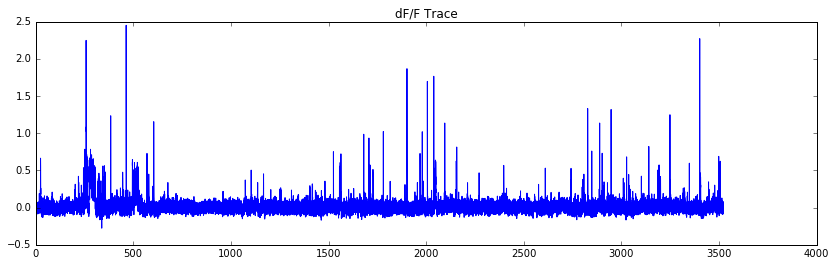

In [223]:
from allensdk.brain_observatory.dff import compute_dff

plt.figure(figsize=(14,4))
plt.title("dF/F Trace")
dff = compute_dff(np.array(corrected_traces))
plt.plot(time, dff[0,:])
plt.show()


In [224]:
dff.shape, scenes.shape


((1, 105710), (118, 918, 1174))

In [226]:
#we make the design matrix, and corresponding dff array - using the stimulus table to tell us when a natural image was presented.
import cv2

stim_array = []
dff_array = []


for index, row in stim_table.iterrows():
    for i in range(row['start'], row['end']):
        stim_array.append(cv2.resize(scenes[row.frame,:,:], (100, 100)))
        dff_array.append(dff[0, i])
        
dff_array = np.array(dff_array)[:, np.newaxis]
stim_array = np.array(stim_array).reshape([41887, 100*100])


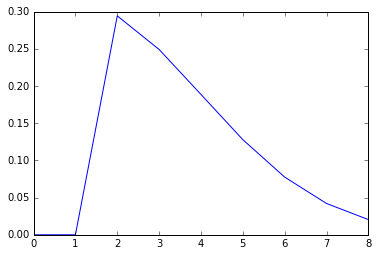

In [257]:
from scipy.stats import norm

n = 16
basis = norm.pdf(range(0, n), loc = n/2, scale = n/5)

basis = basis[7:]
basis[0] = 0
basis[1] = 0
basis /= sum(basis)

plt.plot( basis)
plt.show()

l, n = stim_array.shape

for i in range(n):
    stim_array[:, i] = np.squeeze(np.convolve(stim_array[:, i], basis)[0:l])

(-0.5, 1173.5, -0.5, 917.5)

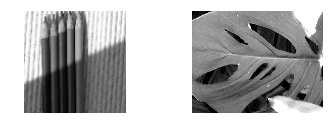

In [256]:
#we plot the stimulus

plt.subplot(221)
plt.imshow(stim_array[17].reshape(100, 100), cmap = 'gray')
plt.axis('off')

plt.subplot(222)
plt.imshow(scenes[stim_table.frame[0]], cmap ='gray', origin = 'lower')
plt.axis('off')


In [265]:
print stim_array.shape, np.ones(l).shape

stim_array = np.column_stack((stim_array, np.ones(l)))

print stim_array.shape,

(41887, 10001) (41887,)
(41887, 10002)


In [266]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stim_array, dff_array, test_size = .25, random_state = 0)


In [267]:
#this takes a long time...
weight_init = np.linalg.pinv(X_train).dot(y_train)


In [268]:
weight_init.shape


(10002, 1)

In [ ]:
import tensorflow as tf

exp_model = gm.exponential_GLM(10002, weight_init, alpha = 0, non_lin = tf.sigmoid, lr = .01, bias_init = 1, scale_init= 5)

L, l  = exp_model.fit(X_train, y_train, X_test, y_test, batch_size = 10000, max_iters=500)


0%                          100%
[***************               ] | ETA: 00:12:42

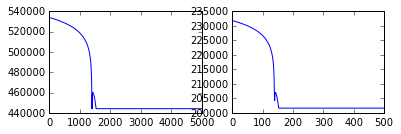

In [148]:
plt.subplot(221)
plt.plot(L)
plt.subplot(222)
plt.plot(l)


In [149]:
w, o, s  = exp_model.get_params()

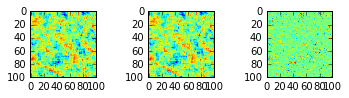

In [150]:
plt.subplot(331)
plt.imshow(w.reshape(100, 100))
plt.subplot(332)
plt.imshow(weight_init.reshape(100, 100))

plt.subplot(333)
plt.imshow(w.reshape(100, 100) - weight_init.reshape(100, 100))

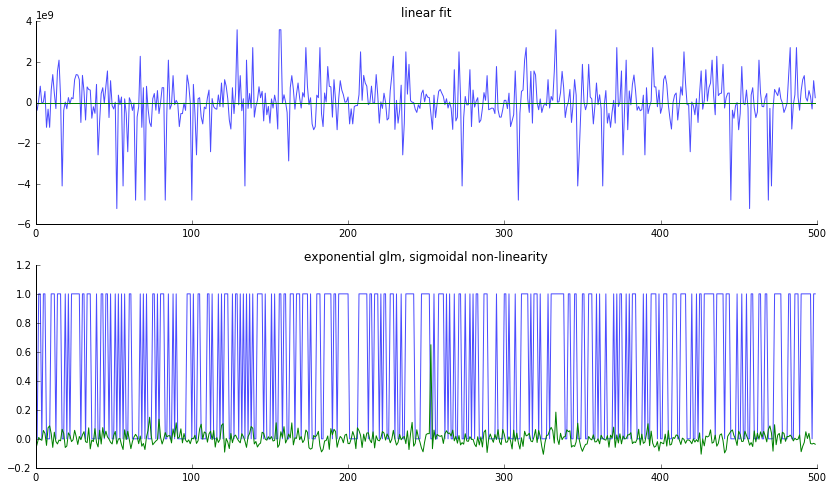

In [151]:
from glm_utils import *

plt.figure(figsize = [14, 8])

ax = plt.subplot(211)
plt.plot((X_test.dot(weight_init))[0:500], alpha = .7)
plt.plot(y_test[0:500], 'g')
plt.title('linear fit')
simpleaxis(ax)

ax = plt.subplot(212)
plt.plot(sigmoid(X_test.dot(w)[0:500]), alpha = .7)
plt.plot(y_test[0:500])
plt.title('exponential glm, sigmoidal non-linearity')
simpleaxis(ax)